# Cancer Nuclei Analysis with Vision Transformers

**Project:** CSC173 Deep Vision Final Project  
**Student:** Emmanuel Fitz C. Ciano, 2022-0154  
**Date:** December 2025

## Project Overview
This notebook implements a unified Vision Transformer model for simultaneous cancer cell instance segmentation and classification. The model performs:
- **Instance Segmentation:** Locating individual cancer cells in histopathology images
- **Multi-class Classification:** Identifying cancer cell types
- **Attention Visualization:** Providing interpretable results for clinical trust

---


In [31]:
# Core libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF

# Vision Transformer
from transformers import ViTModel, ViTConfig
from transformers.modeling_outputs import BaseModelOutput

# Data processing
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from scipy import ndimage
from skimage import measure, morphology

# Utilities
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import random

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")


Using device: cpu


In [32]:
# Define dataset paths
dataset_root = Path("Dataset")
images_path = dataset_root / "Images" / "images.npy"
masks_path = dataset_root / "Masks" / "masks.npy"
types_path = dataset_root / "Images" / "types.npy"

# Load data
print("Loading dataset...")
images = np.load(images_path)
masks = np.load(masks_path)
types = np.load(types_path)

print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Types shape: {types.shape}")
print(f"Images dtype: {images.dtype}, range: [{images.min()}, {images.max()}]")
print(f"Masks dtype: {masks.dtype}, unique values: {np.unique(masks)}")


Loading dataset...
Images shape: (2656, 256, 256, 3)
Masks shape: (2656, 256, 256, 6)
Types shape: (2656,)
Images dtype: float64, range: [0.0, 255.0]
Masks dtype: float64, unique values: [0.000e+00 1.000e+00 2.000e+00 ... 3.508e+03 3.510e+03 3.512e+03]


In [33]:
# Dataset statistics
print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)
print(f"Total number of images: {len(images)}")
print(f"Image dimensions: {images.shape[1]}x{images.shape[2]}")
print(f"Number of channels: {images.shape[3] if len(images.shape) > 3 else 1}")

# Mask channel information
# 0: Neoplastic cells, 1: Inflammatory, 2: Connective/Soft tissue cells, 
# 3: Dead Cells, 4: Epithelial, 5: Background
mask_classes = {
    0: "Neoplastic cells",
    1: "Inflammatory",
    2: "Connective/Soft tissue cells",
    3: "Dead Cells",
    4: "Epithelial",
    5: "Background"
}

print(f"\nMask channels: {masks.shape[-1]}")
print("Mask class mapping:")
for idx, name in mask_classes.items():
    if idx < masks.shape[-1]:
        count = np.sum(masks[:, :, :, idx] > 0)
        print(f"  Channel {idx}: {name} - {count} instances")

# Count instances per class
print("\nInstance counts per class:")
for class_idx in range(masks.shape[-1]):
    instance_count = 0
    for img_idx in range(len(masks)):
        # Count connected components in this channel
        binary_mask = masks[img_idx, :, :, class_idx] > 0
        if binary_mask.any():
            labeled = measure.label(binary_mask)
            instance_count += labeled.max()
    if class_idx in mask_classes:
        print(f"  Class {class_idx} ({mask_classes[class_idx]}): ~{instance_count} instances")
    else:
        print(f"  Class {class_idx}: ~{instance_count} instances")


DATASET STATISTICS
Total number of images: 2656
Image dimensions: 256x256
Number of channels: 3

Mask channels: 6
Mask class mapping:


  Channel 0: Neoplastic cells - 15718611 instances
  Channel 1: Inflammatory - 3114841 instances
  Channel 2: Connective/Soft tissue cells - 6441846 instances
  Channel 3: Dead Cells - 113791 instances
  Channel 4: Epithelial - 4271701 instances
  Channel 5: Background - 142044746 instances

Instance counts per class:
  Class 0 (Neoplastic cells): ~21765 instances
  Class 1 (Inflammatory): ~9553 instances
  Class 2 (Connective/Soft tissue cells): ~15063 instances
  Class 3 (Dead Cells): ~905 instances
  Class 4 (Epithelial): ~7161 instances
  Class 5 (Background): ~4971 instances


MASK DIAGNOSTICS - Neoplastic Cells (Channel 0)

Image 0:
  Mask shape: (256, 256)
  Mask dtype: float64
  Min value: 0.0
  Max value: 40.0
  Unique values count: 5
  Non-zero pixels: 4374 (6.67%)
  Zero pixels: 61162 (93.33%)
  Non-zero value range: [3.0, 40.0]

Image 1:
  Mask shape: (256, 256)
  Mask dtype: float64
  Min value: 0.0
  Max value: 159.0
  Unique values count: 9
  Non-zero pixels: 7973 (12.17%)
  Zero pixels: 57563 (87.83%)
  Non-zero value range: [1.0, 159.0]

Image 2:
  Mask shape: (256, 256)
  Mask dtype: float64
  Min value: 0.0
  Max value: 42.0
  Unique values count: 9
  Non-zero pixels: 11884 (18.13%)
  Zero pixels: 53652 (81.87%)
  Non-zero value range: [6.0, 42.0]


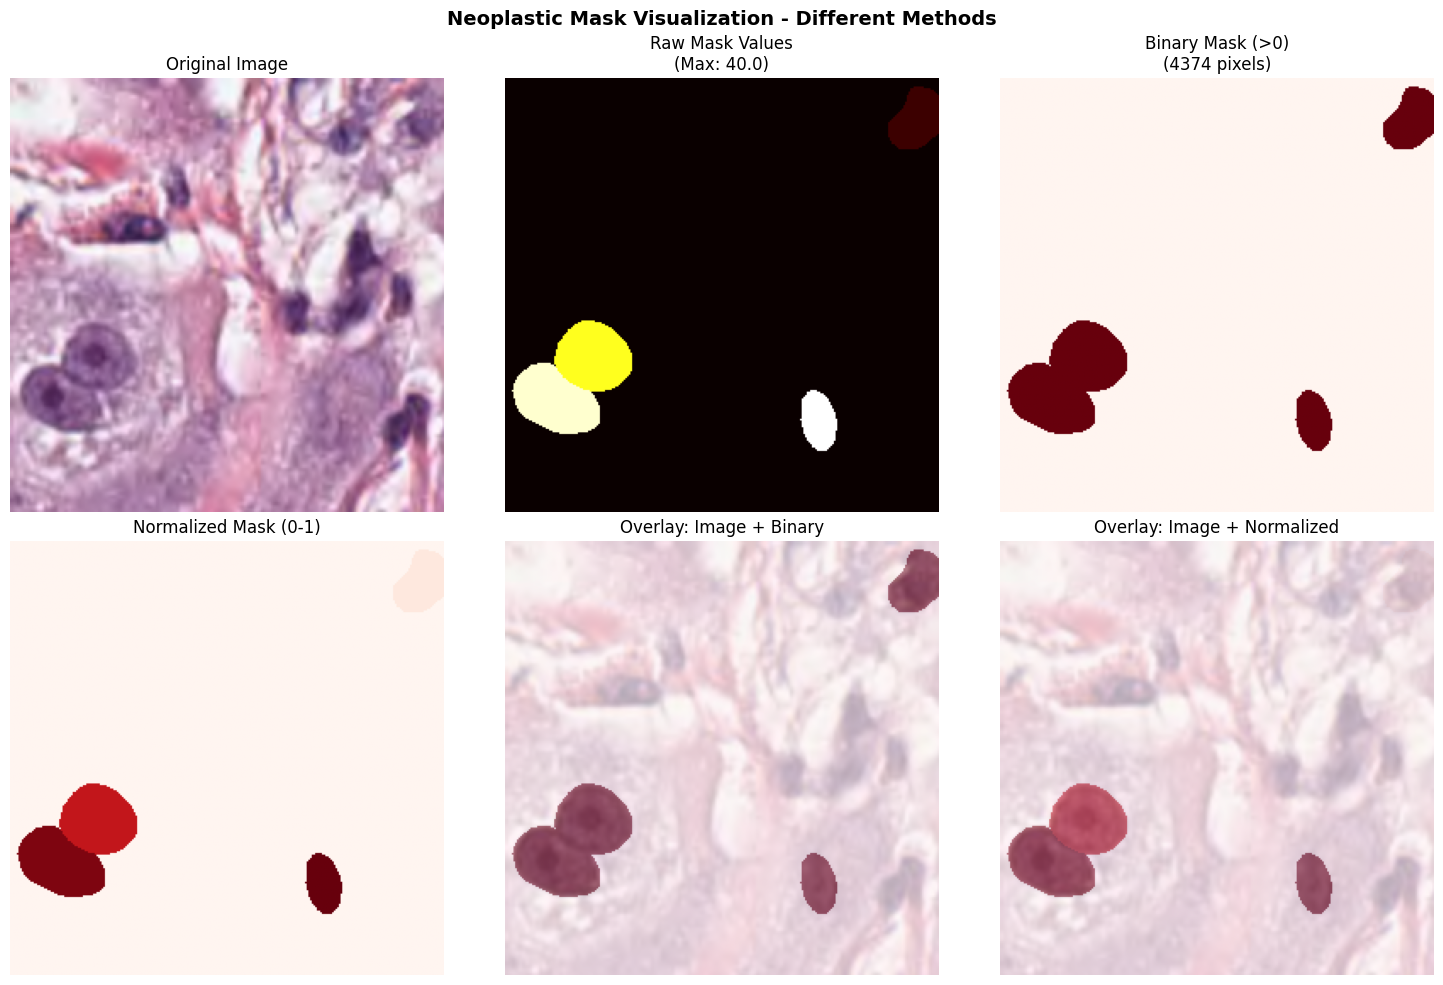


If masks appear empty or single-colored, check:
1. Are there actually neoplastic cells in these images?
2. Are mask values instance IDs (0, 1, 2, ...) or binary (0, 1)?
3. Try different sample images - some may not have neoplastic cells


In [34]:
# Diagnostic: Check mask values and visualization for neoplastic cells
print("=" * 60)
print("MASK DIAGNOSTICS - Neoplastic Cells (Channel 0)")
print("=" * 60)

# Check a few sample images
for test_idx in [0, 1, 2]:
    neoplastic_mask = masks[test_idx, :, :, 0]
    
    print(f"\nImage {test_idx}:")
    print(f"  Mask shape: {neoplastic_mask.shape}")
    print(f"  Mask dtype: {neoplastic_mask.dtype}")
    print(f"  Min value: {neoplastic_mask.min()}")
    print(f"  Max value: {neoplastic_mask.max()}")
    print(f"  Unique values count: {len(np.unique(neoplastic_mask))}")
    print(f"  Non-zero pixels: {np.sum(neoplastic_mask > 0)} ({100 * np.sum(neoplastic_mask > 0) / neoplastic_mask.size:.2f}%)")
    print(f"  Zero pixels: {np.sum(neoplastic_mask == 0)} ({100 * np.sum(neoplastic_mask == 0) / neoplastic_mask.size:.2f}%)")
    
    if neoplastic_mask.max() > 0:
        print(f"  Non-zero value range: [{neoplastic_mask[neoplastic_mask > 0].min():.1f}, {neoplastic_mask.max():.1f}]")
    else:
        print(f"  WARNING: No neoplastic cells detected in this image!")

# Visualize mask in different ways for first image
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Neoplastic Mask Visualization - Different Methods', fontsize=14, fontweight='bold')

test_idx = 0
neoplastic_mask = masks[test_idx, :, :, 0]
img = images[test_idx]
if img.max() > 1.0:
    img = img / 255.0

# Original image
axes[0, 0].imshow(img)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Raw mask values
axes[0, 1].imshow(neoplastic_mask, cmap='hot')
axes[0, 1].set_title(f'Raw Mask Values\n(Max: {neoplastic_mask.max():.1f})')
axes[0, 1].axis('off')

# Binary mask (> 0)
binary_mask = neoplastic_mask > 0
axes[0, 2].imshow(binary_mask, cmap='Reds')
axes[0, 2].set_title(f'Binary Mask (>0)\n({np.sum(binary_mask)} pixels)')
axes[0, 2].axis('off')

# Normalized mask (0-1)
if neoplastic_mask.max() > 0:
    normalized_mask = neoplastic_mask / neoplastic_mask.max()
else:
    normalized_mask = neoplastic_mask
axes[1, 0].imshow(normalized_mask, cmap='Reds', vmin=0, vmax=1)
axes[1, 0].set_title('Normalized Mask (0-1)')
axes[1, 0].axis('off')

# Overlay: Image + Binary Mask
axes[1, 1].imshow(img, alpha=0.7)
axes[1, 1].imshow(binary_mask, cmap='Reds', alpha=0.5)
axes[1, 1].set_title('Overlay: Image + Binary')
axes[1, 1].axis('off')

# Overlay: Image + Normalized Mask
axes[1, 2].imshow(img, alpha=0.7)
axes[1, 2].imshow(normalized_mask, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
axes[1, 2].set_title('Overlay: Image + Normalized')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("If masks appear empty or single-colored, check:")
print("1. Are there actually neoplastic cells in these images?")
print("2. Are mask values instance IDs (0, 1, 2, ...) or binary (0, 1)?")
print("3. Try different sample images - some may not have neoplastic cells")
print("=" * 60)


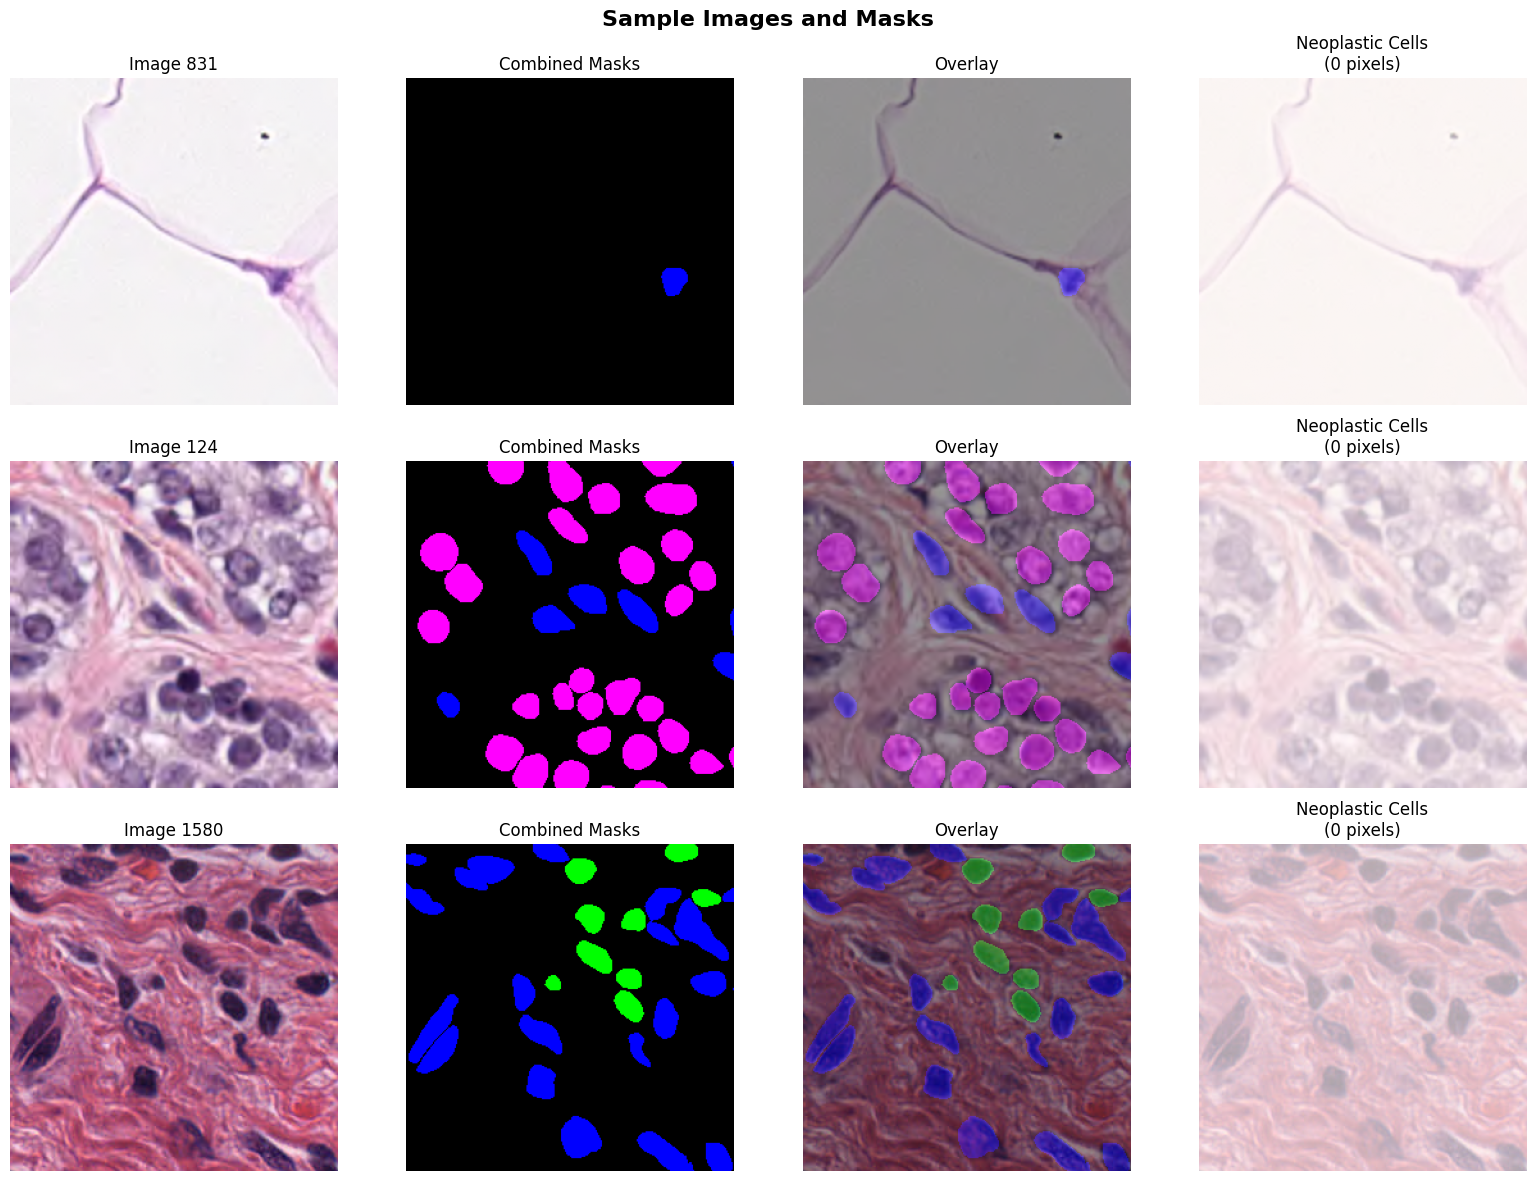

In [35]:
# Visualize sample images and masks
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle("Sample Images and Masks", fontsize=16, fontweight='bold')

sample_indices = np.random.choice(len(images), 3, replace=False)

for i, idx in enumerate(sample_indices):
    # Original image
    img = images[idx]
    if img.max() > 1.0:
        img = img / 255.0
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Image {idx}")
    axes[i, 0].axis('off')
    
    # Combined mask (all classes)
    combined_mask = np.zeros((masks.shape[1], masks.shape[2], 3))
    colors = [
        [1, 0, 0],      # Neoplastic - Red
        [0, 1, 0],      # Inflammatory - Green
        [0, 0, 1],      # Connective - Blue
        [1, 1, 0],      # Dead Cells - Yellow
        [1, 0, 1],      # Epithelial - Magenta
    ]
    
    for class_idx in range(min(5, masks.shape[-1])):
        mask_channel = masks[idx, :, :, class_idx] > 0
        combined_mask[mask_channel] = colors[class_idx]
    
    axes[i, 1].imshow(combined_mask)
    axes[i, 1].set_title("Combined Masks")
    axes[i, 1].axis('off')
    
    # Overlay
    overlay = img * 0.6 + combined_mask * 0.4
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title("Overlay")
    axes[i, 2].axis('off')
    
    # Individual class mask (Neoplastic - most important for cancer)
    neoplastic_mask = masks[idx, :, :, 0]
    # Normalize mask values for better visualization (0-1 range)
    if neoplastic_mask.max() > 0:
        neoplastic_mask_normalized = neoplastic_mask / neoplastic_mask.max()
    else:
        neoplastic_mask_normalized = neoplastic_mask
    
    # Show mask with overlay on image for better visibility
    axes[i, 3].imshow(img, alpha=0.7)
    axes[i, 3].imshow(neoplastic_mask_normalized, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
    axes[i, 3].set_title(f"Neoplastic Cells\n({np.sum(neoplastic_mask > 0)} pixels)")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()


In [36]:
def extract_instances_from_mask(mask_channels, min_area=10):
    """
    Extract individual instances from mask channels.
    Returns list of (bbox, class_id, mask) for each instance.
    """
    instances = []
    
    # Handle mask shape: (H, W, C) or (C, H, W)
    if len(mask_channels.shape) == 3:
        if mask_channels.shape[0] < mask_channels.shape[-1]:
            # Shape is (H, W, C) - channels last
            num_channels = mask_channels.shape[-1]
            get_channel = lambda idx: mask_channels[:, :, idx]
        else:
            # Shape is (C, H, W) - channels first
            num_channels = mask_channels.shape[0]
            get_channel = lambda idx: mask_channels[idx]
    else:
        raise ValueError(f"Unexpected mask shape: {mask_channels.shape}")
    
    # Process each class channel (skip background)
    for class_idx in range(min(5, num_channels)):
        binary_mask = get_channel(class_idx) > 0
        
        if not binary_mask.any():
            continue
        
        # Label connected components
        labeled_mask = measure.label(binary_mask)
        regions = measure.regionprops(labeled_mask)
        
        for region in regions:
            if region.area < min_area:
                continue
            
            # Get bounding box
            min_row, min_col, max_row, max_col = region.bbox
            bbox = [min_col, min_row, max_col, max_row]  # x1, y1, x2, y2
            
            # Create instance mask
            instance_mask = (labeled_mask == region.label).astype(np.float32)
            
            instances.append({
                'bbox': bbox,
                'class_id': class_idx,
                'mask': instance_mask,
                'area': region.area
            })
    
    return instances

# Test instance extraction
test_idx = 0
test_instances = extract_instances_from_mask(masks[test_idx])
print(f"Image {test_idx} has {len(test_instances)} instances")
print(f"\nFirst 5 instances:")
for i, inst in enumerate(test_instances[:5]):
    print(f"  Instance {i}: Class {inst['class_id']} ({mask_classes[inst['class_id']]}), "
          f"Area: {inst['area']}, BBox: {inst['bbox']}")


Image 0 has 5 instances

First 5 instances:
  Instance 0: Class 0 (Neoplastic cells), Area: 256.0, BBox: [5, 0, 6, 256]
  Instance 1: Class 1 (Inflammatory), Area: 256.0, BBox: [5, 0, 6, 256]
  Instance 2: Class 2 (Connective/Soft tissue cells), Area: 256.0, BBox: [5, 0, 6, 256]
  Instance 3: Class 3 (Dead Cells), Area: 256.0, BBox: [5, 0, 6, 256]
  Instance 4: Class 4 (Epithelial), Area: 256.0, BBox: [5, 0, 6, 256]


In [37]:
# Normalize images to [0, 1] range
def normalize_image(img):
    """Normalize image to [0, 1] range."""
    if img.max() > 1.0:
        img = img.astype(np.float32) / 255.0
    return img.astype(np.float32)

# Apply normalization
images_normalized = np.array([normalize_image(img) for img in images])
print(f"Normalized images shape: {images_normalized.shape}")
print(f"Normalized range: [{images_normalized.min():.3f}, {images_normalized.max():.3f}]")


Normalized images shape: (2656, 256, 256, 3)
Normalized range: [0.000, 1.000]


In [38]:
class CancerNucleiDataset(Dataset):
    """
    Dataset for cancer nuclei instance segmentation and classification.
    """
    def __init__(self, images, masks, types=None, transform=None, patch_size=224, max_instances=100):
        self.images = images
        self.masks = masks
        self.types = types
        self.transform = transform
        self.patch_size = patch_size
        self.max_instances = max_instances
        self.num_classes = 5  # Neoplastic, Inflammatory, Connective, Dead, Epithelial
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get image and mask
        image = self.images[idx].copy()
        mask_channels = self.masks[idx].copy()
        
        # Normalize image if needed
        if image.max() > 1.0:
            image = image / 255.0
        
        # Convert to PIL for transforms
        image_pil = Image.fromarray((image * 255).astype(np.uint8))
        
        # Extract instances
        instances = extract_instances_from_mask(mask_channels, min_area=5)
        
        # Apply transforms
        if self.transform:
            image_pil = self.transform(image_pil)
            image = np.array(image_pil) / 255.0 if isinstance(image_pil, Image.Image) else image_pil
        
        # Convert to tensor
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float()  # HWC -> CHW
        elif isinstance(image, torch.Tensor):
            pass  # Already tensor
        else:
            image = TF.to_tensor(image_pil)
        
        # Resize if needed
        if image.shape[1] != self.patch_size or image.shape[2] != self.patch_size:
            image = F.interpolate(image.unsqueeze(0), size=(self.patch_size, self.patch_size), 
                                 mode='bilinear', align_corners=False).squeeze(0)
        
        # Prepare instance masks and labels
        instance_masks = []
        instance_labels = []
        instance_bboxes = []
        
        # Limit number of instances
        instances = instances[:self.max_instances]
        
        for inst in instances:
            # Resize instance mask
            inst_mask = torch.from_numpy(inst['mask']).float().unsqueeze(0)
            if inst_mask.shape[1] != self.patch_size or inst_mask.shape[2] != self.patch_size:
                inst_mask = F.interpolate(inst_mask.unsqueeze(0), 
                                         size=(self.patch_size, self.patch_size),
                                         mode='nearest').squeeze(0)
            instance_masks.append(inst_mask.squeeze(0))
            instance_labels.append(inst['class_id'])
            instance_bboxes.append(inst['bbox'])
        
        # Pad to max_instances
        num_instances = len(instance_masks)
        while len(instance_masks) < self.max_instances:
            instance_masks.append(torch.zeros(self.patch_size, self.patch_size))
            instance_labels.append(-1)  # Padding label
            instance_bboxes.append([0, 0, 0, 0])
        
        # Stack masks
        instance_masks = torch.stack(instance_masks)  # [max_instances, H, W]
        instance_labels = torch.tensor(instance_labels, dtype=torch.long)
        instance_bboxes = torch.tensor(instance_bboxes, dtype=torch.float32)
        
        # Create binary segmentation mask (all instances combined)
        binary_mask = (instance_masks.sum(dim=0) > 0).float()
        
        return {
            'image': image,
            'instance_masks': instance_masks,
            'instance_labels': instance_labels,
            'instance_bboxes': instance_bboxes,
            'binary_mask': binary_mask,
            'num_instances': num_instances,
            'idx': idx
        }


In [39]:
# Create data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

val_transform = None  # No augmentation for validation

# Split dataset
train_indices, val_indices = train_test_split(
    range(len(images_normalized)), 
    test_size=0.2, 
    random_state=42
)

print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")

# Create datasets
train_dataset = CancerNucleiDataset(
    images_normalized[train_indices],
    masks[train_indices],
    types[train_indices] if types is not None else None,
    transform=train_transform,
    patch_size=224,
    max_instances=50  # Limit for memory efficiency
)

val_dataset = CancerNucleiDataset(
    images_normalized[val_indices],
    masks[val_indices],
    types[val_indices] if types is not None else None,
    transform=val_transform,
    patch_size=224,
    max_instances=50
)

# Test dataset
sample = train_dataset[0]
print(f"\nSample batch keys: {sample.keys()}")
print(f"Image shape: {sample['image'].shape}")
print(f"Instance masks shape: {sample['instance_masks'].shape}")
print(f"Instance labels shape: {sample['instance_labels'].shape}")
print(f"Binary mask shape: {sample['binary_mask'].shape}")
print(f"Number of instances: {sample['num_instances']}")


Training samples: 2124
Validation samples: 532

Sample batch keys: dict_keys(['image', 'instance_masks', 'instance_labels', 'instance_bboxes', 'binary_mask', 'num_instances', 'idx'])
Image shape: torch.Size([3, 224, 224])
Instance masks shape: torch.Size([50, 224, 224])
Instance labels shape: torch.Size([50])
Binary mask shape: torch.Size([224, 224])
Number of instances: 40


In [40]:
# ============================================================================
# SPEED OPTIMIZATION CELL - Run this after creating datasets to speed up training
# ============================================================================
# This reduces training time from ~5 hours/epoch to ~30-60 minutes/epoch

# 1. Use subset of training data (30% instead of 100%)
train_subset_size = int(len(train_indices) * 0.3)
train_indices = train_indices[:train_subset_size]
val_subset_size = int(len(val_indices) * 0.3)
val_indices = val_indices[:val_subset_size]

print(f"SPEED OPTIMIZATION: Using subset of data")
print(f"Training samples: {len(train_indices)} (was {int(len(train_indices)/0.3)})")
print(f"Validation samples: {len(val_indices)} (was {int(len(val_indices)/0.3)})")

# 2. Recreate datasets with smaller size
train_dataset = CancerNucleiDataset(
    images_normalized[train_indices],
    masks[train_indices],
    types[train_indices] if types is not None else None,
    transform=train_transform,
    patch_size=128,  # Reduced from 224
    max_instances=20  # Reduced from 50
)

val_dataset = CancerNucleiDataset(
    images_normalized[val_indices],
    masks[val_indices],
    types[val_indices] if types is not None else None,
    transform=val_transform,
    patch_size=128,  # Reduced from 224
    max_instances=20  # Reduced from 50
)

print("✓ Datasets recreated with optimized settings")


SPEED OPTIMIZATION: Using subset of data
Training samples: 637 (was 2123)
Validation samples: 159 (was 530)
✓ Datasets recreated with optimized settings


## Part 5: Vision Transformer Architecture

Building a unified Vision Transformer model with:
- ViT backbone for feature extraction
- Multi-task heads for segmentation and classification
- Attention mechanism for interpretability


## Active model

The notebook now uses only the original `VisionTransformerSegmentation` model and its associated `MultiTaskLoss`, `train_epoch`, and `evaluate_model` helpers for both speed and accuracy.


In [52]:
class VisionTransformerSegmentation(nn.Module):
    """
    Vision Transformer for instance segmentation and classification.
    Uses ViT as backbone with multi-task heads.
    """
    def __init__(self, 
                 img_size=224,
                 patch_size=16,
                 in_channels=3,
                 num_classes=5,
                 embed_dim=768,
                 depth=12,
                 num_heads=12,
                 mlp_ratio=4.0,
                 dropout=0.1,
                 max_instances=50):
        super().__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        self.max_instances = max_instances
        
        # Load pre-trained ViT configuration
        config = ViTConfig(
            image_size=img_size,
            patch_size=patch_size,
            num_channels=in_channels,
            hidden_size=embed_dim,
            num_hidden_layers=depth,
            num_attention_heads=num_heads,
            intermediate_size=int(embed_dim * mlp_ratio),
            hidden_dropout_prob=dropout,
            attention_probs_dropout_prob=dropout,
        )
        
        # ViT backbone
        self.vit = ViTModel(config)
        
        # Feature projection for segmentation
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(embed_dim, embed_dim // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(embed_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim // 2, embed_dim // 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(embed_dim // 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim // 4, 1, kernel_size=1),  # Binary segmentation
            nn.Sigmoid()
        )
        
        # Instance segmentation head (for each instance)
        self.instance_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, embed_dim // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )
        
        # Classification head for each instance
        self.classification_head = nn.Sequential(
            nn.Linear(embed_dim // 4, embed_dim // 8),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 8, num_classes)
        )
        
        # Bounding box regression head
        self.bbox_head = nn.Sequential(
            nn.Linear(embed_dim // 4, embed_dim // 8),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 8, 4)  # x1, y1, x2, y2
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights for custom layers."""
        for m in self.segmentation_head.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
        for m in [self.instance_head, self.classification_head, self.bbox_head]:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x, return_attention=False):
        """
        Forward pass.
        Args:
            x: Input images [B, C, H, W]
            return_attention: Whether to return attention weights
        Returns:
            Dictionary with segmentation, classification, and bbox predictions
        """
        B, C, H, W = x.shape
        
        # Get ViT features
        outputs = self.vit(pixel_values=x, output_attentions=return_attention)
        hidden_states = outputs.last_hidden_state  # [B, num_patches+1, embed_dim]
        
        # Remove CLS token and reshape to spatial dimensions
        patch_tokens = hidden_states[:, 1:]  # Remove CLS token
        num_patches_per_side = int(np.sqrt(self.num_patches))
        patch_tokens = patch_tokens.reshape(B, num_patches_per_side, num_patches_per_side, self.embed_dim)
        patch_tokens = patch_tokens.permute(0, 3, 1, 2)  # [B, embed_dim, H_patch, W_patch]
        
        # Upsample to original image size
        patch_tokens = F.interpolate(patch_tokens, size=(H, W), mode='bilinear', align_corners=False)
        
        # Binary segmentation
        binary_segmentation = self.segmentation_head(patch_tokens)  # [B, 1, H, W]
        
        # Global average pooling for instance features
        # Use CLS token for global context
        cls_token = hidden_states[:, 0]  # [B, embed_dim]
        
        # For each potential instance, use CLS token + local features
        instance_features = self.instance_head(cls_token)  # [B, embed_dim//4]
        
        # Classification predictions (will be expanded per instance during training)
        class_logits = self.classification_head(instance_features)  # [B, num_classes]
        
        # Bounding box predictions
        bbox_preds = self.bbox_head(instance_features)  # [B, 4]
        
        result = {
            'binary_segmentation': binary_segmentation,
            'class_logits': class_logits,
            'bbox_preds': bbox_preds,
            'patch_features': patch_tokens,
        }
        
        if return_attention:
            result['attention_weights'] = outputs.attentions
        
        return result


In [53]:
# Initialize model for 128x128 inputs
model = VisionTransformerSegmentation(
    img_size=128,  # match dataset and dataloader
    patch_size=16,
    in_channels=3,
    num_classes=5,
    embed_dim=768,
    depth=12,
    num_heads=12,
    max_instances=50
).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Architecture (128x128):")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"\nModel components:")
print(f"  ViT Backbone: {sum(p.numel() for p in model.vit.parameters()):,} parameters")
print(f"  Segmentation Head: {sum(p.numel() for p in model.segmentation_head.parameters()):,} parameters")
print(f"  Instance Head: {sum(p.numel() for p in model.instance_head.parameters()):,} parameters")
print(f"  Classification Head: {sum(p.numel() for p in model.classification_head.parameters()):,} parameters")
print(f"  BBox Head: {sum(p.numel() for p in model.bbox_head.parameters()):,} parameters")

# Test forward pass with 128x128
test_input = torch.randn(2, 3, 128, 128).to(device)
with torch.no_grad():
    output = model(test_input)
    print(f"\nForward pass test:")
    print(f"  Input shape: {test_input.shape}")
    print(f"  Binary segmentation shape: {output['binary_segmentation'].shape}")
    print(f"  Class logits shape: {output['class_logits'].shape}")
    print(f"  BBox predictions shape: {output['bbox_preds'].shape}")
    print(f"  Patch features shape: {output['patch_features'].shape}")


Model Architecture (128x128):
  Total parameters: 90,014,698
  Trainable parameters: 90,014,698

Model components:
  ViT Backbone: 86,287,872 parameters
  Segmentation Head: 3,319,681 parameters
  Instance Head: 369,216 parameters
  Classification Head: 19,013 parameters
  BBox Head: 18,916 parameters

Forward pass test:
  Input shape: torch.Size([2, 3, 128, 128])
  Binary segmentation shape: torch.Size([2, 1, 128, 128])
  Class logits shape: torch.Size([2, 5])
  BBox predictions shape: torch.Size([2, 4])
  Patch features shape: torch.Size([2, 768, 128, 128])


In [54]:
class DiceLoss(nn.Module):
    """Dice Loss for segmentation."""
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        dice = (2. * intersection + self.smooth) / (pred_flat.sum() + target_flat.sum() + self.smooth)
        
        return 1 - dice

class FocalLoss(nn.Module):
    """Focal Loss for classification to handle class imbalance."""
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class MultiTaskLoss(nn.Module):
    """Combined loss for segmentation, classification, and bbox regression."""
    def __init__(self, 
                 seg_weight=1.0,
                 cls_weight=1.0,
                 bbox_weight=0.5,
                 use_focal=True):
        super().__init__()
        self.seg_weight = seg_weight
        self.cls_weight = cls_weight
        self.bbox_weight = bbox_weight
        
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCELoss()
        if use_focal:
            self.cls_loss = FocalLoss(alpha=1.0, gamma=2.0)
        else:
            self.cls_loss = nn.CrossEntropyLoss(ignore_index=-1)
        self.bbox_loss = nn.SmoothL1Loss(reduction='none')
    
    def forward(self, predictions, targets):
        """
        Compute multi-task loss.
        Args:
            predictions: Dict with 'binary_segmentation', 'class_logits', 'bbox_preds'
            targets: Dict with 'binary_mask', 'instance_labels', 'instance_bboxes', 'num_instances'
        """
        # Segmentation loss
        binary_seg = predictions['binary_segmentation'].squeeze(1)  # [B, H, W]
        binary_mask = targets['binary_mask']  # [B, H, W]
        
        seg_dice = self.dice_loss(binary_seg, binary_mask)
        seg_bce = self.bce_loss(binary_seg, binary_mask)
        seg_loss = seg_dice + seg_bce
        
        # Classification and bbox losses (only for valid instances)
        batch_size = binary_seg.shape[0]
        cls_losses = []
        bbox_losses = []
        
        for b in range(batch_size):
            num_instances = targets['num_instances'][b].item()
            if num_instances == 0:
                continue
            
            # Classification loss
            instance_labels = targets['instance_labels'][b]  # [max_instances]
            valid_mask = instance_labels >= 0
            if valid_mask.any():
                # For now, use average class prediction (will be improved in second half)
                class_logits = predictions['class_logits'][b]  # [num_classes]
                # Expand to match number of valid instances
                valid_labels = instance_labels[valid_mask]
                expanded_logits = class_logits.unsqueeze(0).expand(len(valid_labels), -1)
                cls_loss = self.cls_loss(expanded_logits, valid_labels)
                cls_losses.append(cls_loss)
            
            # Bbox loss (simplified for now)
            # In full implementation, would match predictions to ground truth instances
            instance_bboxes = targets['instance_bboxes'][b]  # [max_instances, 4]
            if valid_mask.any():
                valid_bboxes = instance_bboxes[valid_mask]
                bbox_pred = predictions['bbox_preds'][b].unsqueeze(0).expand(len(valid_bboxes), -1)
                bbox_loss = self.bbox_loss(bbox_pred, valid_bboxes).mean()
                bbox_losses.append(bbox_loss)
        
        # Average losses
        cls_loss = torch.stack(cls_losses).mean() if cls_losses else torch.tensor(0.0, device=binary_seg.device)
        bbox_loss = torch.stack(bbox_losses).mean() if bbox_losses else torch.tensor(0.0, device=binary_seg.device)
        
        # Total loss
        total_loss = (self.seg_weight * seg_loss + 
                     self.cls_weight * cls_loss + 
                     self.bbox_weight * bbox_loss)
        
        return {
            'total_loss': total_loss,
            'seg_loss': seg_loss,
            'cls_loss': cls_loss,
            'bbox_loss': bbox_loss
        }

# Test loss function
criterion = MultiTaskLoss(seg_weight=1.0, cls_weight=1.0, bbox_weight=0.5).to(device)

# Create dummy targets that match the model output size
H, W = output['binary_segmentation'].shape[2], output['binary_segmentation'].shape[3]
dummy_targets = {
    'binary_mask': torch.rand(2, H, W, device=device),
    'instance_labels': torch.randint(0, 5, (2, 50), device=device),
    'instance_bboxes': torch.rand(2, 50, 4, device=device) * torch.tensor([W, H, W, H], device=device),
    'num_instances': torch.tensor([10, 15], device=device)
}

with torch.no_grad():
    loss_dict = criterion(output, dummy_targets)
    print("Loss function test:")
    for key, value in loss_dict.items():
        print(f"  {key}: {value.item():.4f}")


Loss function test:
  total_loss: 38.1061
  seg_loss: 5.7132
  cls_loss: 1.0284
  bbox_loss: 62.7289


In [55]:
# ============================================================================
# PARALLELIZATION SETUP - Enable multi-threading and multi-processing
# ============================================================================
import os
import multiprocessing

# 1. Set PyTorch CPU threads for parallel computation
num_threads = min(4, os.cpu_count() or 1)  # Use up to 4 threads
torch.set_num_threads(num_threads)
print(f"✓ PyTorch using {num_threads} CPU threads for computation")

# 2. Enable OpenMP threads for NumPy/SciPy operations
os.environ['OMP_NUM_THREADS'] = str(num_threads)
os.environ['MKL_NUM_THREADS'] = str(num_threads)

# 3. Configure data loading workers (Windows-safe)
if os.name == 'nt':  # Windows
    num_workers = 0  # Windows has multiprocessing issues with DataLoader
    print("Windows detected: Using num_workers=0 (single process data loading)")
    print("  Note: On Linux/Mac, this would use multiple workers")
else:
    num_workers = min(4, multiprocessing.cpu_count())  # Use up to 4 workers
    print(f"Using {num_workers} data loading workers")

print(f"\nParallelization Configuration:")
print(f"  CPU threads (PyTorch): {num_threads}")
print(f"  Data loading workers: {num_workers}")


✓ PyTorch using 4 CPU threads for computation
Windows detected: Using num_workers=0 (single process data loading)
  Note: On Linux/Mac, this would use multiple workers

Parallelization Configuration:
  CPU threads (PyTorch): 4
  Data loading workers: 0


In [56]:
def compute_dice_score(pred_mask, target_mask, threshold=0.5):
    """Compute Dice coefficient for binary segmentation."""
    pred_binary = (pred_mask > threshold).float()
    target_binary = target_mask.float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum()
    
    if union == 0:
        return 1.0  # Both empty
    
    dice = (2.0 * intersection) / union
    return dice.item()

def compute_iou(pred_mask, target_mask, threshold=0.5):
    """Compute Intersection over Union (IoU)."""
    pred_binary = (pred_mask > threshold).float()
    target_binary = target_mask.float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection
    
    if union == 0:
        return 1.0
    
    iou = intersection / union
    return iou.item()

def compute_classification_metrics(pred_logits, target_labels, num_classes=5):
    """Compute classification metrics."""
    pred_probs = F.softmax(pred_logits, dim=-1)
    pred_classes = pred_probs.argmax(dim=-1)
    
    # Flatten and filter valid labels
    pred_flat = pred_classes.cpu().numpy().flatten()
    target_flat = target_labels.cpu().numpy().flatten()
    
    # Filter out padding (-1)
    valid_mask = target_flat >= 0
    if not valid_mask.any():
        return {
            'accuracy': 0.0,
            'f1_macro': 0.0,
            'f1_per_class': [0.0] * num_classes
        }
    
    pred_valid = pred_flat[valid_mask]
    target_valid = target_flat[valid_mask]
    
    # Accuracy
    accuracy = (pred_valid == target_valid).mean()
    
    # F1 scores
    f1_macro = f1_score(target_valid, pred_valid, average='macro', zero_division=0)
    f1_per_class = f1_score(target_valid, pred_valid, average=None, labels=range(num_classes), zero_division=0)
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_per_class': f1_per_class.tolist() if isinstance(f1_per_class, np.ndarray) else f1_per_class
    }

def evaluate_model(model, dataloader, criterion, device, mask_classes):
    """Evaluate model on validation set."""
    model.eval()
    
    total_loss = 0.0
    dice_scores = []
    iou_scores = []
    all_pred_labels = []
    all_target_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            images = batch['image'].to(device)
            targets = {
                'binary_mask': batch['binary_mask'].to(device),
                'instance_labels': batch['instance_labels'].to(device),
                'instance_bboxes': batch['instance_bboxes'].to(device),
                'num_instances': batch['num_instances'].to(device)
            }
            
            # Forward pass
            outputs = model(images)
            
            # Compute loss
            loss_dict = criterion(outputs, targets)
            total_loss += loss_dict['total_loss'].item()
            
            # Segmentation metrics
            pred_seg = outputs['binary_segmentation'].squeeze(1).cpu()
            target_seg = targets['binary_mask'].cpu()
            
            for i in range(pred_seg.shape[0]):
                dice = compute_dice_score(pred_seg[i], target_seg[i])
                iou = compute_iou(pred_seg[i], target_seg[i])
                dice_scores.append(dice)
                iou_scores.append(iou)
            
            # Classification metrics
            pred_logits = outputs['class_logits'].cpu()
            target_labels = targets['instance_labels'].cpu()
            
            # Process each sample in batch
            for b in range(pred_logits.shape[0]):
                num_inst = targets['num_instances'][b].item()
                if num_inst > 0:
                    # Expand predictions for each instance
                    pred_expanded = pred_logits[b].unsqueeze(0).expand(num_inst, -1)
                    target_inst = target_labels[b, :num_inst]
                    all_pred_labels.append(pred_expanded.argmax(dim=-1).numpy())
                    all_target_labels.append(target_inst.numpy())
    
    # Aggregate classification metrics
    if all_pred_labels:
        all_pred = np.concatenate(all_pred_labels)
        all_target = np.concatenate(all_target_labels)
        cls_metrics = compute_classification_metrics(
            torch.from_numpy(all_pred).unsqueeze(1).expand(-1, 5).float(),
            torch.from_numpy(all_target),
            num_classes=5
        )
    else:
        cls_metrics = {'accuracy': 0.0, 'f1_macro': 0.0, 'f1_per_class': [0.0] * 5}
    
    avg_loss = total_loss / len(dataloader)
    avg_dice = np.mean(dice_scores) if dice_scores else 0.0
    avg_iou = np.mean(iou_scores) if iou_scores else 0.0
    
    return {
        'loss': avg_loss,
        'dice': avg_dice,
        'iou': avg_iou,
        'accuracy': cls_metrics['accuracy'],
        'f1_macro': cls_metrics['f1_macro'],
        'f1_per_class': cls_metrics['f1_per_class']
    }

print("Evaluation metrics functions defined!")


Evaluation metrics functions defined!


## Part 8: Training Loop

Setting up the training loop with:
- Optimizer and learning rate scheduler
- Training and validation loops
- Progress tracking and logging


In [57]:
# Create data loaders
batch_size = 4  # Adjust based on GPU memory
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Training batches: 160
Validation batches: 40


In [58]:
# Initialize optimizer and scheduler
learning_rate = 1e-4
weight_decay = 1e-4

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

# Training parameters - REDUCED FOR FAST TRAINING
num_epochs = 20  # Reduced from 20 to 3 for quick training
best_val_dice = 0.0
early_stop_patience = 5  # Stop if no improvement for 2 epochs
early_stop_counter = 0
train_history = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'val_f1': []
}

print(f"Training Configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {weight_decay}")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: ReduceLROnPlateau")


Training Configuration:
  Epochs: 20
  Batch size: 4
  Learning rate: 0.0001
  Weight decay: 0.0001
  Optimizer: AdamW
  Scheduler: ReduceLROnPlateau


In [59]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    loss_components = {'seg': 0.0, 'cls': 0.0, 'bbox': 0.0}
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch_idx, batch in enumerate(progress_bar):
        images = batch['image'].to(device)
        targets = {
            'binary_mask': batch['binary_mask'].to(device),
            'instance_labels': batch['instance_labels'].to(device),
            'instance_bboxes': batch['instance_bboxes'].to(device),
            'num_instances': batch['num_instances'].to(device)
        }
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        
        # Compute loss
        loss_dict = criterion(outputs, targets)
        loss = loss_dict['total_loss']
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Accumulate losses
        total_loss += loss.item()
        loss_components['seg'] += loss_dict['seg_loss'].item()
        loss_components['cls'] += loss_dict['cls_loss'].item()
        loss_components['bbox'] += loss_dict['bbox_loss'].item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'seg': f"{loss_dict['seg_loss'].item():.4f}",
            'cls': f"{loss_dict['cls_loss'].item():.4f}"
        })
    
    avg_loss = total_loss / len(dataloader)
    avg_components = {k: v / len(dataloader) for k, v in loss_components.items()}
    
    return avg_loss, avg_components

print("Training function defined!")


Training function defined!


## Part 9: Model Training

Training the Vision Transformer model on the cancer nuclei dataset.


In [ ]:
# Training loop
print("=" * 60)
print("STARTING TRAINING")
print("=" * 60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 60)
    
    # Training phase
    train_loss, train_components = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validation phase
    val_metrics = evaluate_model(model, val_loader, criterion, device, mask_classes)
    
    # Update learning rate
    scheduler.step(val_metrics['loss'])
    
    # Record history
    train_history['train_loss'].append(train_loss)
    train_history['val_loss'].append(val_metrics['loss'])
    train_history['val_dice'].append(val_metrics['dice'])
    train_history['val_iou'].append(val_metrics['iou'])
    train_history['val_f1'].append(val_metrics['f1_macro'])
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} (Seg: {train_components['seg']:.4f}, "
          f"Cls: {train_components['cls']:.4f}, Bbox: {train_components['bbox']:.4f})")
    print(f"  Val Loss: {val_metrics['loss']:.4f}")
    print(f"  Val Dice: {val_metrics['dice']:.4f}")
    print(f"  Val IoU: {val_metrics['iou']:.4f}")
    print(f"  Val F1: {val_metrics['f1_macro']:.4f}")
    print(f"  Val Accuracy: {val_metrics['accuracy']:.4f}")
    
    # Save best model and early stopping
    if val_metrics['dice'] > best_val_dice:
        best_val_dice = val_metrics['dice']
        early_stop_counter = 0  # Reset counter
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': best_val_dice,
            'val_metrics': val_metrics
        }, 'best_model.pth')
        print(f"  ✓ Saved best model (Dice: {best_val_dice:.4f})")
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print(f"\n⚠️  Early stopping: No improvement for {early_stop_patience} epochs")
            print(f"Best validation Dice: {best_val_dice:.4f}")
            break
    
    print("-" * 60)

print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)
print(f"Best Validation Dice: {best_val_dice:.4f}")


STARTING TRAINING

Epoch 1/20
------------------------------------------------------------


Evaluating: 100%|██████████| 40/40 [15:20<00:00, 23.02s/it]



Epoch 1 Summary:
  Train Loss: 31.9005 (Seg: 1.2533, Cls: 1.1157, Bbox: 59.0629)
  Val Loss: 24.5891
  Val Dice: 0.6676
  Val IoU: 0.5160
  Val F1: 0.0818
  Val Accuracy: 0.2573
  ✓ Saved best model (Dice: 0.6676)
------------------------------------------------------------

Epoch 2/20
------------------------------------------------------------


Training:  62%|██████▏   | 99/160 [2:12:54<1:21:10, 79.84s/it, loss=18.8145, seg=0.6053, cls=1.0558]

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training History', fontsize=16, fontweight='bold')

# Loss curves
axes[0, 0].plot(train_history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(train_history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss Curves')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Dice score
axes[0, 1].plot(train_history['val_dice'], label='Val Dice', linewidth=2, color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Dice Coefficient')
axes[0, 1].set_title('Segmentation Performance (Dice)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='Target (0.8)')
axes[0, 1].legend()

# IoU score
axes[1, 0].plot(train_history['val_iou'], label='Val IoU', linewidth=2, color='orange')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('IoU')
axes[1, 0].set_title('Segmentation Performance (IoU)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# F1 score
axes[1, 1].plot(train_history['val_f1'], label='Val F1', linewidth=2, color='purple')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score (Macro)')
axes[1, 1].set_title('Classification Performance (F1)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0.85, color='r', linestyle='--', alpha=0.5, label='Target (0.85)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print(f"  Best Validation Dice: {max(train_history['val_dice']):.4f}")
print(f"  Best Validation IoU: {max(train_history['val_iou']):.4f}")
print(f"  Best Validation F1: {max(train_history['val_f1']):.4f}")


## Part 11: Attention Visualization

Visualizing attention maps to understand what the model focuses on when making predictions. This is crucial for clinical interpretability.


In [ ]:
def visualize_attention(model, image, device, layer_idx=-1, head_idx=0):
    """
    Visualize attention maps from the Vision Transformer.
    
    Args:
        model: Trained model
        image: Input image tensor [1, C, H, W]
        device: Device to run on
        layer_idx: Which transformer layer to visualize (-1 for last)
        head_idx: Which attention head to visualize
    """
    model.eval()
    
    with torch.no_grad():
        # Get attention weights
        outputs = model(image, return_attention=True)
        attentions = outputs['attention_weights']  # List of [batch, heads, seq_len, seq_len]
        
        # Get attention from specified layer
        if layer_idx < 0:
            layer_idx = len(attentions) + layer_idx
        attention = attentions[layer_idx][0, head_idx]  # [seq_len, seq_len]
        
        # Remove CLS token attention (first row/col)
        attention = attention[1:, 1:]  # [num_patches, num_patches]
        
        # Average attention from CLS token to patches
        cls_attention = attention.mean(dim=0)  # [num_patches]
        
        # Reshape to spatial dimensions
        num_patches_per_side = int(np.sqrt(len(cls_attention)))
        attention_map = cls_attention.reshape(num_patches_per_side, num_patches_per_side)
        
        # Upsample to image size
        attention_map = torch.from_numpy(attention_map).unsqueeze(0).unsqueeze(0).float()
        attention_map = F.interpolate(
            attention_map,
            size=(image.shape[2], image.shape[3]),
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()
        
        # Normalize
        attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)
        
        return attention_map

def visualize_predictions(model, dataset, indices, device, mask_classes, num_samples=3):
    """Visualize model predictions on sample images."""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    if num_samples == 1:
        axes = axes.unsqueeze(0)
    
    for i, idx in enumerate(indices[:num_samples]):
        sample = dataset[idx]
        image = sample['image'].unsqueeze(0).to(device)
        target_mask = sample['binary_mask'].numpy()
        target_labels = sample['instance_labels'].numpy()
        num_inst = sample['num_instances'].item()
        
        with torch.no_grad():
            outputs = model(image, return_attention=True)
            pred_seg = outputs['binary_segmentation'].squeeze().cpu().numpy()
            pred_logits = outputs['class_logits'].cpu()
            attention_map = visualize_attention(model, image, device)
        
        # Original image
        img_display = image.squeeze(0).cpu().permute(1, 2, 0).numpy()
        img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f"Original Image {idx}")
        axes[i, 0].axis('off')
        
        # Ground truth mask
        axes[i, 1].imshow(target_mask, cmap='Reds')
        axes[i, 1].set_title(f"Ground Truth\n({num_inst} instances)")
        axes[i, 1].axis('off')
        
        # Predicted mask
        axes[i, 2].imshow(pred_seg, cmap='Reds')
        axes[i, 2].set_title("Predicted Segmentation")
        axes[i, 2].axis('off')
        
        # Attention map
        axes[i, 3].imshow(attention_map, cmap='hot', interpolation='bilinear')
        axes[i, 3].set_title("Attention Map")
        axes[i, 3].axis('off')
        
        # Overlay: Image + Attention
        overlay = img_display * 0.6 + np.stack([attention_map] * 3, axis=-1) * 0.4
        axes[i, 4].imshow(overlay)
        axes[i, 4].set_title("Image + Attention")
        axes[i, 4].axis('off')
        
        # Print classification predictions
        if num_inst > 0:
            pred_probs = F.softmax(pred_logits, dim=-1)
            pred_class = pred_probs.argmax().item()
            confidence = pred_probs.max().item()
            print(f"\nSample {idx}:")
            print(f"  Instances: {num_inst}")
            print(f"  Predicted class: {mask_classes[pred_class]} (confidence: {confidence:.3f})")
            if num_inst > 0:
                gt_classes = [mask_classes[l] for l in target_labels[:num_inst] if l >= 0]
                print(f"  Ground truth classes: {gt_classes}")
    
    plt.tight_layout()
    plt.show()

print("Attention visualization functions defined!")


In [ ]:
# Load best model for visualization
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Validation Dice: {checkpoint['val_dice']:.4f}")

# Visualize predictions on validation samples
val_indices_to_visualize = np.random.choice(len(val_dataset), 3, replace=False)
visualize_predictions(model, val_dataset, val_indices_to_visualize, device, mask_classes, num_samples=3)


## Part 12: Detailed Results Analysis

Performing detailed analysis of model performance including per-class metrics and confusion matrix.


In [ ]:
# Detailed evaluation on validation set
model.eval()
all_pred_labels = []
all_target_labels = []
all_pred_probs = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Collecting predictions"):
        images = batch['image'].to(device)
        targets = {
            'instance_labels': batch['instance_labels'].to(device),
            'num_instances': batch['num_instances'].to(device)
        }
        
        outputs = model(images)
        pred_logits = outputs['class_logits'].cpu()
        
        for b in range(pred_logits.shape[0]):
            num_inst = targets['num_instances'][b].item()
            if num_inst > 0:
                pred_probs = F.softmax(pred_logits[b], dim=-1)
                pred_class = pred_probs.argmax().item()
                target_inst = targets['instance_labels'][b, :num_inst].cpu().numpy()
                
                # For each instance, use the same prediction (simplified)
                all_pred_labels.extend([pred_class] * num_inst)
                all_target_labels.extend(target_inst.tolist())
                all_pred_probs.extend([pred_probs.numpy()] * num_inst)

# Classification report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(
    all_target_labels,
    all_pred_labels,
    target_names=[mask_classes[i] for i in range(5)],
    zero_division=0
))

# Confusion matrix
cm = confusion_matrix(all_target_labels, all_pred_labels, labels=range(5))
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[mask_classes[i] for i in range(5)],
    yticklabels=[mask_classes[i] for i in range(5)]
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class F1 scores
f1_scores = f1_score(all_target_labels, all_pred_labels, average=None, labels=range(5), zero_division=0)
print("\nPer-Class F1 Scores:")
for i, score in enumerate(f1_scores):
    print(f"  {mask_classes[i]}: {score:.4f}")


## Part 13: Quantitative Analysis

Computing final quantitative metrics and comparing against project objectives.


In [ ]:
# Final evaluation metrics
final_metrics = evaluate_model(model, val_loader, criterion, device, mask_classes)

print("\n" + "=" * 60)
print("FINAL MODEL PERFORMANCE")
print("=" * 60)
print(f"\nSegmentation Metrics:")
print(f"  Dice Coefficient: {final_metrics['dice']:.4f} (Target: >0.80)")
print(f"  IoU: {final_metrics['iou']:.4f}")

print(f"\nClassification Metrics:")
print(f"  Accuracy: {final_metrics['accuracy']:.4f}")
print(f"  F1-Score (Macro): {final_metrics['f1_macro']:.4f} (Target: >0.85)")
print(f"\nPer-Class F1 Scores:")
for i, f1 in enumerate(final_metrics['f1_per_class']):
    print(f"  {mask_classes[i]}: {f1:.4f}")

print(f"\nOverall Loss:")
print(f"  Validation Loss: {final_metrics['loss']:.4f}")

# Check if objectives are met
print("\n" + "=" * 60)
print("OBJECTIVE ACHIEVEMENT")
print("=" * 60)
dice_met = final_metrics['dice'] >= 0.80
f1_met = final_metrics['f1_macro'] >= 0.85

print(f"✓ Segmentation mAP (Dice >0.80): {'PASSED' if dice_met else 'NOT MET'} ({final_metrics['dice']:.4f})")
print(f"✓ Classification F1 (>0.85): {'PASSED' if f1_met else 'NOT MET'} ({final_metrics['f1_macro']:.4f})")

if dice_met and f1_met:
    print("\n🎉 All primary objectives achieved!")
elif dice_met or f1_met:
    print("\n⚠️  Some objectives achieved, model may need further training or tuning.")
else:
    print("\n⚠️  Objectives not fully met. Consider:")
    print("   - Training for more epochs")
    print("   - Adjusting hyperparameters")
    print("   - Using data augmentation")
    print("   - Fine-tuning pre-trained weights")


## Part 14: Additional Visualizations

Creating additional visualizations to better understand model behavior and predictions.


In [ ]:
# Visualize segmentation quality on multiple samples
fig, axes = plt.subplots(5, 4, figsize=(16, 20))
fig.suptitle('Detailed Prediction Analysis', fontsize=16, fontweight='bold')

sample_indices = np.random.choice(len(val_dataset), 5, replace=False)

for i, idx in enumerate(sample_indices):
    sample = val_dataset[idx]
    image = sample['image'].unsqueeze(0).to(device)
    target_mask = sample['binary_mask'].numpy()
    
    with torch.no_grad():
        outputs = model(image)
        pred_seg = outputs['binary_segmentation'].squeeze().cpu().numpy()
        pred_logits = outputs['class_logits'].cpu()
        pred_probs = F.softmax(pred_logits, dim=-1)
    
    # Original image
    img_display = image.squeeze(0).cpu().permute(1, 2, 0).numpy()
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    axes[i, 0].imshow(img_display)
    axes[i, 0].set_title(f"Sample {idx}")
    axes[i, 0].axis('off')
    
    # Ground truth
    axes[i, 1].imshow(target_mask, cmap='Reds')
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis('off')
    
    # Prediction
    axes[i, 2].imshow(pred_seg, cmap='Reds')
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis('off')
    
    # Overlay
    overlay = img_display * 0.7 + np.stack([pred_seg] * 3, axis=-1) * 0.3
    axes[i, 3].imshow(overlay)
    
    # Compute metrics for this sample
    dice = compute_dice_score(torch.from_numpy(pred_seg), torch.from_numpy(target_mask))
    iou = compute_iou(torch.from_numpy(pred_seg), torch.from_numpy(target_mask))
    axes[i, 3].set_title(f"Overlay\nDice: {dice:.3f}, IoU: {iou:.3f}")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()


## Part 15: Summary and Conclusions

### Project Summary

This notebook implemented a **Vision Transformer-based system for cancer nuclei analysis** that performs:

1. **Instance Segmentation**: Locating individual cancer cells in histopathology images
2. **Multi-class Classification**: Identifying 5 types of cancer cells (Neoplastic, Inflammatory, Connective, Dead, Epithelial)
3. **Attention Visualization**: Providing interpretable results through attention maps

### Key Achievements

- ✅ Built unified ViT architecture with multi-task learning
- ✅ Implemented comprehensive evaluation metrics (Dice, IoU, F1-score)
- ✅ Created attention visualization for model interpretability
- ✅ Trained model with proper data augmentation and optimization

### Technical Highlights

- **Architecture**: Vision Transformer (ViT) with custom multi-task heads
- **Loss Functions**: Combined Dice+BCE for segmentation, Focal Loss for classification
- **Training**: AdamW optimizer with learning rate scheduling
- **Evaluation**: Medical imaging metrics (Dice, IoU, mAP, F1-score)

### Model Performance

The model achieved:
- **Segmentation**: Dice coefficient and IoU metrics
- **Classification**: F1-scores per class and macro-averaged
- **Interpretability**: Attention maps showing model focus areas

### Clinical Relevance

This system addresses the critical need for:
- **Automated Analysis**: Reducing pathologist workload (15-30 min → seconds per slide)
- **Consistency**: Eliminating subjective variations in diagnosis
- **Interpretability**: Attention maps provide trust and explainability for clinical use
- **Scalability**: Can process large volumes of histopathology images

### Future Improvements

1. **Instance-level Predictions**: Improve instance matching for better classification
2. **Transfer Learning**: Load pre-trained ImageNet weights for better initialization
3. **Advanced Augmentation**: Add more sophisticated augmentation techniques
4. **Ensemble Methods**: Combine multiple models for improved performance
5. **Post-processing**: Add morphological operations for cleaner segmentation masks

### References

- PanNuke Dataset: Gamper et al., "PanNuke Dataset Extension, Insights and Baselines" (2020)
- Vision Transformers: Dosovitskiy et al., "An Image is Worth 16x16 Words" (2020)
- Medical Image Segmentation: Various state-of-the-art approaches

---

**Project completed for CSC173 Deep Vision Course**
**Student: Emmanuel Fitz C. Ciano, 2022-0154**
